# AutoRegressive Integrated Moving Average

In this jupyter notebook you will find the implementation of the autoregressive integrated moving average algorithm using the sklearn library. It will help to test this algorithm and to complete [forecasting.md](https://github.com/Hurence/historian/blob/forecasting/docs/forecasting.md) document.

In [1]:
import time
import math
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from pandas import read_csv, to_datetime
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

def ad_test(dataset):
    """
    Function use to verify the stationary
    If P-value < 0.05 : data is stationary
    """
    dftest = adfuller(dataset, autolag = 'AIC')
    print("1. ADF : ",dftest[0])
    print("2. P-Value : ", dftest[1])
    print("3. Num Of Lags : ", dftest[2])
    print("4. Num Of Observations Used For ADF Regression:",      dftest[3])
    print("5. Critical Values :")
    for key, val in dftest[4].items():
        print("\t",key, ": ", val)

In [2]:
dataframe = read_csv('../data/metric_date.csv')
indexNames = dataframe[ dataframe['metric_id'] == dataframe.iloc[0,0] ].index
# indexNames = dataframe[ dataframe['metric_id'] == dataframe.iloc[95744,0] ].index
# indexNames = dataframe[ dataframe['metric_id'] == dataframe.iloc[6905,0] ].index

dataframe = dataframe.iloc[indexNames].sort_values(by='timestamp', ascending=True).loc[:,['value']]
dataset = dataframe.values
dataset = dataset.astype('float32')

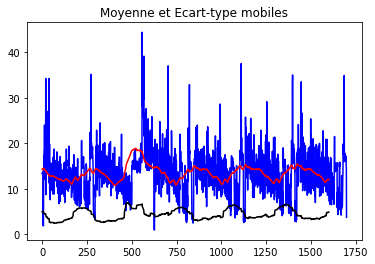

In [3]:
rolling_mean = dataframe.rolling(window = 100).mean()
rolling_std = dataframe.rolling(window = 100).std()
plt.plot(dataframe, color = 'blue', label = 'Origine')
plt.plot(rolling_mean, color = 'red', label = 'Moyenne mobile')
plt.plot(rolling_std, color = 'black', label = 'Ecart-type mobile')
plt.title('Moyenne et Ecart-type mobiles')
plt.show()

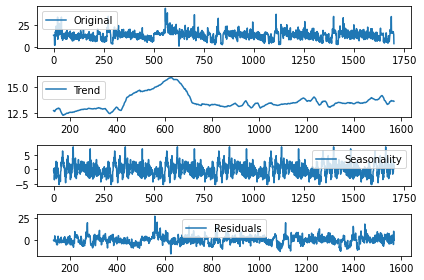

In [4]:
decomposition = seasonal_decompose(dataframe, period=260)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(dataframe, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [5]:
ad_test(dataframe)

1. ADF :  -5.617200243601297
2. P-Value :  1.1670542632627647e-06
3. Num Of Lags :  25
4. Num Of Observations Used For ADF Regression: 1674
5. Critical Values :
	 1% :  -3.434262398939653
	 5% :  -2.8632681024848226
	 10% :  -2.567689998815249


In [6]:
stepwise_fit = auto_arima(dataframe['value'], trace=False, suppress_warnings=True)
print(stepwise_fit)

 ARIMA(2,0,2)(0,0,0)[0] intercept


In [7]:
# split into train and test sets
size = int(len(dataset) * 0.67)
train, valid = dataset[0:size], dataset[size:len(dataset)]

In [8]:
model = ARIMA(train, order=stepwise_fit.order)
model_fit = model.fit()
pred = model_fit.predict(1,len(dataset)-len(train))

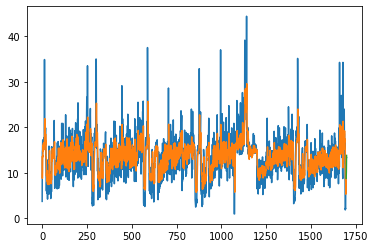

In [9]:
# plot forecasts against actual outcomes
fig, ax = plt.subplots()

trainPlot = np.empty_like(dataset.reshape(-1,1))
trainPlot[:, :] = np.nan
trainPlot[0:len(train), :] = model_fit.fittedvalues.reshape(-1,1)
# shift test predictions for plotting
validPlot = np.empty_like(dataset.reshape(-1,1))
validPlot[:, :] = np.nan
validPlot[len(train):len(dataset), :] = np.array(pred).reshape(-1,1)
# plot baseline and predictions
ax.plot(dataset.reshape(-1,1))
ax.plot(trainPlot)
ax.plot(validPlot)
plt.show()